### Setup

In [1]:
# Environment
import numpy as np
import pandas as pd
from MesoPy import Meso
import matplotlib.pyplot as plt

meso_token="4192c18707b848299783d59a9317c6e1"
m=Meso(meso_token)

### Data Read

Below we print all the RAWS stations in Colorado with full data availability over the time period in question. The search and output is done in the notebook `fine_RAWS_station`.,

Note: the time period is arbitrary at this point, and the `find_RAWS_station` notebook summarized this data availability for this particular time period. We need to consider how this should work for a different time period. Question: will a particular STID give different available data series for different times, or always the same data series names?

In [2]:
# Read Mesonet data

vars='air_temp,relative_humidity,precip_accum,fuel_moisture'
time_start = "201806010800"  # June 1 2018 08:00 in format yyyymmddHHMM
time_end   = "201907200900"  # June 20 2018 09:00 in format yyyymmddHHMM 
stations = pd.read_csv("station_df_co.csv")
stations[stations["fuel_moisture"]==1].head()

,STID,air_temp,relative_humidity,precip_accum,fuel_moisture
123,CPTC2,1,1,1,1
124,CHAC2,1,1,1,1
125,CHRC2,1,1,1,1
144,LKGC2,1,1,1,1
149,CCEC2,1,1,1,1


In [3]:
meso_ts = m.timeseries(time_start, time_end, 
                       stid="CPTC2", vars=vars)
station = meso_ts['STATION'][0]

Organize RAWS data.

In [4]:
import data_funcs as datf

raws_dat = datf.format_raws(station)

Text(0, 0.5, 'Relative Humidity (%)')

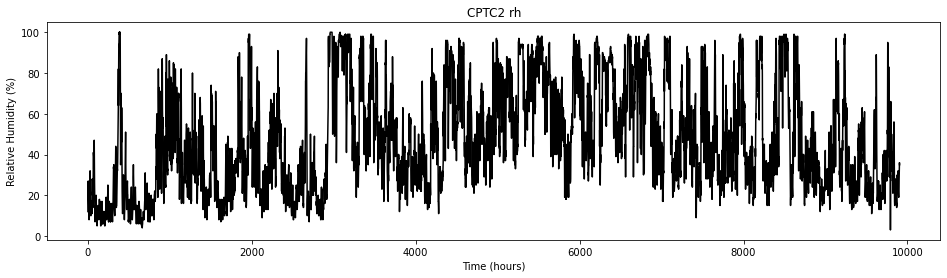

In [5]:
%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(raws_dat['rh'],linestyle='-',c='k')
plt.title(station['STID'] + ' rh')
plt.xlabel('Time (hours)') 
plt.ylabel('Relative Humidity (%)')

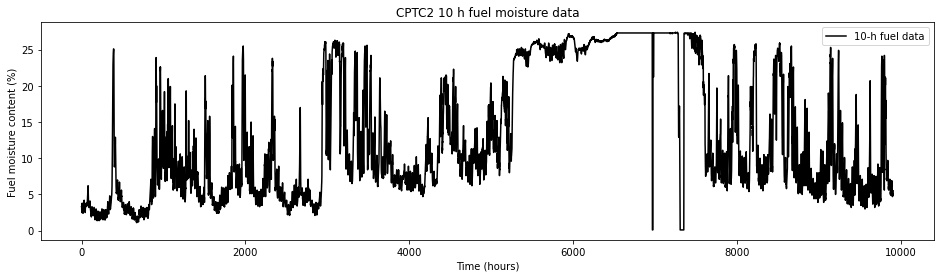

In [6]:
from datetime import datetime, timedelta, time
import numpy as np
import matplotlib.pyplot as plt
import pytz

%matplotlib inline
plt.figure(figsize=(16,4))
plt.plot(raws_dat['fm'],linestyle='-',c='k',label='10-h fuel data')
plt.title(station['STID'] + ' 10 h fuel moisture data')
plt.xlabel('Time (hours)') 
plt.ylabel('Fuel moisture content (%)')
plt.legend()

## Run Augmented Moisture Model with RAWS Data

In [7]:
import moisture_models as mod

## Model params

hours=1200 # total simulation
h2 = 300
m = np.zeros(hours) # preallocate
m[0]= raws_dat['fm'][0]             # initial state  
P = np.zeros(hours)
P[0] = 1e-3 # background state variance
H = np.array([1.])   # all oQ = np.array([0.02]) # process noise variancebserved
Q = np.array([1e-3]) # process noise variance
R = np.array([1e-3]) # data variance

Augmented Model

In [8]:
m,Ec = mod.run_augmented_kf(raws_dat['fm'],raws_dat['Ed'],raws_dat['Ew'],raws_dat['rain'],h2,hours)  # extract from state

In [9]:
def plot_moisture(hmin,hmax):
  print('training from 0 to',h2,'plot from',hmin,'to',hmax)
  plt.figure(figsize=(16,4))
  plt.plot(range(hmin,hmax),raws_dat['Ed'][hmin:hmax],linestyle='--',c='r',label='Drying Equilibrium (%)')
  plt.plot(range(hmin,hmax),raws_dat['Ew'][hmin:hmax],linestyle='--',c='b',label='Wetting Equilibrium (%)')
  plt.plot(range(hmin,hmax),Ec[hmin:hmax],linestyle='--',c='g',label='Equilibrium Correction (%)')
  plt.plot(range(hmin,hmax),m[hmin:hmax],linestyle='-',c='k',label='filtered')
  plt.plot(range(hmin,hmax),raws_dat['fm'][hmin:hmax],linestyle='-',c='b',label='RAWS data (%)')
  plt.plot(range(hmin,hmax),raws_dat['rain'][hmin:hmax],linestyle='-',c='b',label='RTMA rain (mm/h)')
  if hmin>=h2:
    plt.plot(m[hmin:h2],linestyle='-',c='k',label='Filtered')
  h1 = np.maximum(hmin,h2)
  plt.plot(range(h1,hmax),m[h1:hmax],linestyle='-',c='r',label='Forecast (%)')
  plt.title(station['STID'] +' Kalman filtering and forecast with augmented state, real data. Training 0:%i hmax' % h2)
  plt.xlabel('Time (hours)') 
  plt.ylabel('Fuel moisture content (%)')
  plt.legend()

training from 0 to 300 plot from 0 to 1200


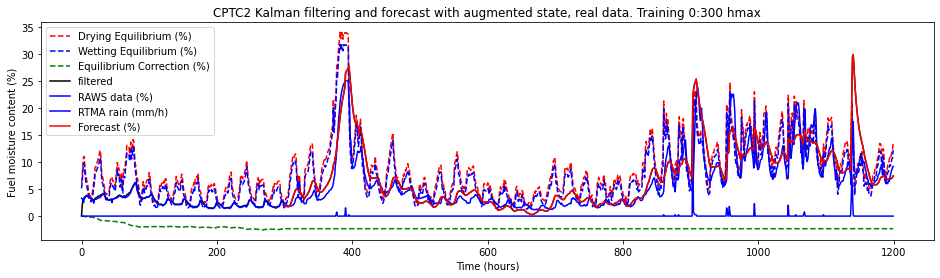

In [10]:
plot_moisture(0,hours)

training from 0 to 300 plot from 1000 to 1200


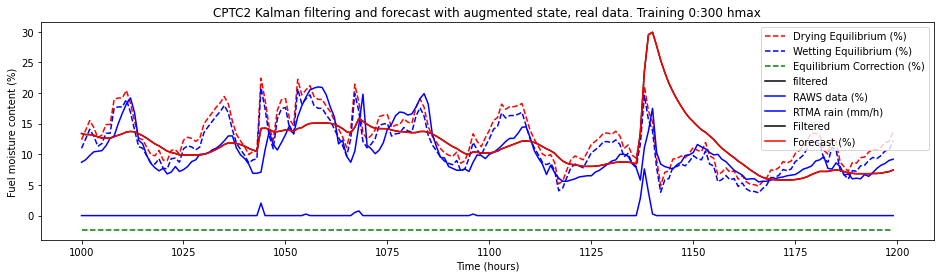

In [11]:
plot_moisture(1000,hours)

## Model Validation

Calculate Mean Absolute Prediction Error (MAPE) for the forecast versus observed fuel moisture data. For comparison, I will calculate MAPE for the entire series, the forecast period, and just the final value (where errors may have accumulated up to).

In [12]:
def mape(a1, a2):
    if a1.shape==():
        n=1
    else:
        n = len(a1)
    err = 1/n*np.sum(np.abs(a1-a2)/np.abs(a1))
    return err

In [13]:
print('Total MAPE: '+ str(np.round(mape(raws_dat['fm'][0:hours], m), 5)))
print('-'*25)
print('Train Period: '+ str(np.round(mape(raws_dat['fm'][0:300], m[0:300]), 5)))
print('-'*25)
print('Test Period: '+ str(np.round(mape(raws_dat['fm'][301:hours], m[301:hours]), 5)))
print('-'*25)
print('Final Time: '+ str(np.round(mape(raws_dat['fm'][-1], m[-1]), 5)))

Total MAPE: 0.23795
-------------------------
Train Period: 0.04431
-------------------------
Test Period: 0.30275
-------------------------
Final Time: 0.35216
